In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score,
    balanced_accuracy_score
)

from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import joblib
try:
    import umap
    UMAP_AVAILABLE = True
except:
    UMAP_AVAILABLE = False
    print("UMAP not installed (optional). pip install umap-learn")

/opt/anaconda3/envs/aml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BASE_DIR = "results"

def p(*parts):
    return os.path.join(BASE_DIR, *parts)

def first_existing(paths):
    return next((fp for fp in paths if fp and os.path.exists(fp)), None)

expr_path = first_existing([p("normalized_expression.csv"), "normalized_expression.csv"])
meta_path = first_existing([p("sample_metadata.csv"), "sample_metadata.csv"])

if expr_path is None:
    raise FileNotFoundError("normalized_expression.csv not found in results/ or notebook folder.")
if meta_path is None:
    raise FileNotFoundError("sample_metadata.csv not found in results/ or notebook folder.")

expr = pd.read_csv(expr_path, index_col=0)
meta = pd.read_csv(meta_path)

# Set sample index
if "sample_id" in meta.columns:
    meta = meta.set_index("sample_id")
else:
    meta = meta.set_index(meta.columns[0])

# Align samples
common = expr.columns.intersection(meta.index)
if len(common) == 0:
    raise ValueError("No overlapping sample IDs between expr columns and meta index.")
expr = expr[common]
meta = meta.loc[common]

print("expr shape (genes x samples):", expr.shape)
print("meta shape (samples x cols):", meta.shape)
print("meta columns:", list(meta.columns))

expr shape (genes x samples): (8506, 163)
meta shape (samples x cols): (163, 4)
meta columns: ['title', 'source', 'characteristics', 'condition']


##  Labels (Auto-detect) → y (0/1)

In [6]:
def find_label_col(meta_df):
    candidates = ["condition", "group", "status", "phenotype", "label", "class"]
    for c in candidates:
        if c in meta_df.columns:
            return c
    obj_cols = [c for c in meta_df.columns if meta_df[c].dtype == "object"]
    return obj_cols[0] if obj_cols else None

LABEL_COL = find_label_col(meta)
if LABEL_COL is None:
    raise ValueError("No label column found. Add a column like 'condition'.")

vals = meta[LABEL_COL].astype(str).str.strip()
uniq = sorted(vals.unique())
print("LABEL_COL:", LABEL_COL)
print("Label values:", uniq)

# Prefer a sleep_deprived-like label if present
pos_candidates = ["sleep_deprived", "sleep deprived", "deprived", "sd", "case", "treated", "disease"]
POS_LABEL = None
for pc in pos_candidates:
    for u in uniq:
        if pc.lower() == u.lower():
            POS_LABEL = u
            break
    if POS_LABEL is not None:
        break

if POS_LABEL is None:
    # fallback: choose the label with larger count as positive (often "case")
    counts = vals.value_counts()
    POS_LABEL = counts.index[0]

NEG_LABEL = [u for u in uniq if u != POS_LABEL][0] if len(uniq) == 2 else "NEG"
y = (vals.values == POS_LABEL).astype(int)

print("POS_LABEL:", POS_LABEL)
print("NEG_LABEL:", NEG_LABEL)
print("Class balance [0,1]:", np.bincount(y))

LABEL_COL: condition
Label values: ['normal_sleep', 'sleep_deprived']
POS_LABEL: sleep_deprived
NEG_LABEL: normal_sleep
Class balance [0,1]: [71 92]


## Optional Probe → Gene Symbol Mapping (for labeled plots)

In [9]:
map_path = first_existing([p("probe_to_symbol_human.csv"), "probe_to_symbol_human.csv", p("id_mapping/probe_to_symbol_human.csv")])

probe_to_symbol = {}
if map_path is not None:
    map_df = pd.read_csv(map_path)
    print("Loaded mapping:", map_path, "cols:", list(map_df.columns))

    # heuristic detection
    probe_col = map_df.columns[0]
    symbol_col = map_df.columns[1] if len(map_df.columns) > 1 else map_df.columns[0]

    probe_to_symbol = map_df.set_index(map_df[probe_col].astype(str))[symbol_col].astype(str).to_dict()
    print("Mapping size:", len(probe_to_symbol))
else:
    print("No probe_to_symbol_human.csv found (OK).")

def pretty_label(fid):
    s = probe_to_symbol.get(str(fid), None)
    return f"{fid} ({s})" if (s is not None and s != "nan") else str(fid)

Loaded mapping: results/id_mapping/probe_to_symbol_human.csv cols: ['probe_id', 'symbol', 'entrezgene', 'name', 'taxid']
Mapping size: 52


## Sanity Checks 

In [12]:
print("Duplicate sample IDs in meta index:", meta.index.duplicated().sum())
print("Duplicate sample columns in expr:", expr.columns.duplicated().sum())

X_all = expr.T.values
corr = np.corrcoef(X_all)
np.fill_diagonal(corr, 0)
print("Max inter-sample correlation (excluding self):", corr.max())

Duplicate sample IDs in meta index: 0
Duplicate sample columns in expr: 0
Max inter-sample correlation (excluding self): 0.9869482266204113


In [14]:
# Identify the most correlated sample pair
corr_df = pd.DataFrame(corr, index=expr.columns, columns=expr.columns)

max_pair = np.unravel_index(np.argmax(corr_df.values), corr_df.shape)
s1 = corr_df.index[max_pair[0]]
s2 = corr_df.columns[max_pair[1]]
max_val = corr_df.values[max_pair]

print("Most correlated pair:")
print(s1, "vs", s2)
print("Correlation:", max_val)

Most correlated pair:
GSM2600228 vs GSM2600227
Correlation: 0.9869482266204113


In [16]:
print(meta.loc[[s1, s2], LABEL_COL])

GSM2600228    sleep_deprived
GSM2600227    sleep_deprived
Name: condition, dtype: object


## HVGs and PCA

In [20]:
HVG_K = 2000

gene_var = expr.var(axis=1)
HVG = gene_var.sort_values(ascending=False).head(HVG_K).index

X_unsup = expr.loc[HVG].T.values
X_unsup = StandardScaler().fit_transform(X_unsup)

print("Using", len(HVG), "HVG genes")

Using 2000 HVG genes


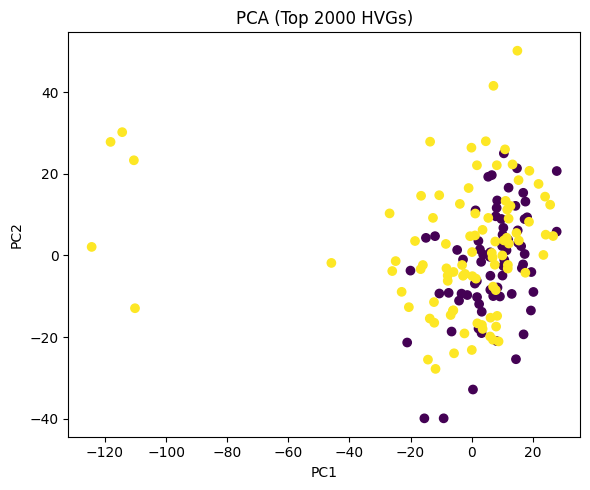

In [22]:
Z_pca = PCA(n_components=2, random_state=42).fit_transform(X_unsup)

plt.figure(figsize=(6,5))
plt.scatter(Z_pca[:,0], Z_pca[:,1], c=y)
plt.title("PCA (Top 2000 HVGs)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

## UMAP

/opt/anaconda3/envs/aml/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


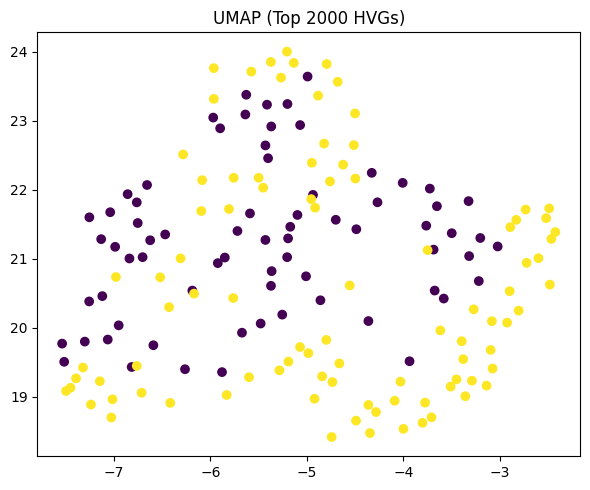

In [25]:
if UMAP_AVAILABLE:
    Z_umap = umap.UMAP(n_neighbors=15, min_dist=0.2, random_state=42).fit_transform(X_unsup)

    plt.figure(figsize=(6,5))
    plt.scatter(Z_umap[:,0], Z_umap[:,1], c=y)
    plt.title("UMAP (Top 2000 HVGs)")
    plt.tight_layout()
    plt.show()

In [65]:
# METADATA DISTRIBUTIONS
print("Condition counts:")
print(meta["condition"].value_counts(dropna=False))

print("\nSource counts:")
print(meta["source"].value_counts(dropna=False))

print("\nMissing values per column:")
print(meta.isna().sum())

Condition counts:
condition
sleep_deprived    92
normal_sleep      71
Name: count, dtype: int64

Source counts:
source
blood    163
Name: count, dtype: int64

Missing values per column:
title              0
source             0
characteristics    0
condition          0
dtype: int64


## Train / Holdout Split

In [28]:
samples = np.array(expr.columns)

train_samps, hold_samps, y_train, y_hold = train_test_split(
    samples,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

expr_train = expr[train_samps]
expr_hold  = expr[hold_samps]

print("Train samples:", expr_train.shape[1])
print("Holdout samples:", expr_hold.shape[1])

Train samples: 130
Holdout samples: 33


## Leak-Free Gene Ranking Function

In [31]:
def rank_genes_train_only(expr_df, y_train, method="score", top_k=100):
    grp1 = expr_df.loc[:, y_train == 1]
    grp0 = expr_df.loc[:, y_train == 0]

    tstat, pvals = ttest_ind(grp1.values, grp0.values, axis=1,
                             equal_var=False, nan_policy="omit")

    mean1 = np.mean(grp1.values, axis=1)
    mean0 = np.mean(grp0.values, axis=1)
    log2fc = mean1 - mean0

    padj = multipletests(pvals, method="fdr_bh")[1]

    df = pd.DataFrame({
        "gene": expr_df.index,
        "log2FC": log2fc,
        "padj": padj
    }).set_index("gene")

    df["abs_log2FC"] = np.abs(df["log2FC"])
    df["score"] = (-np.log10(df["padj"] + 1e-300)) * df["abs_log2FC"]

    if method == "padj":
        ranked = df.sort_values("padj").index
    elif method == "abs_log2fc":
        ranked = df.sort_values("abs_log2FC", ascending=False).index
    else:
        ranked = df.sort_values("score", ascending=False).index

    return list(ranked[:top_k]), df

## Nested Inner CV (Hyperparameter Grid)

In [34]:
def inner_cv_score(expr_df, y01, top_k, rank_method, C, l1_ratio,
                   use_hvg=True, hvg_k=2000,
                   n_splits=5, random_state=42):

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    aucs = []
    cols = np.array(expr_df.columns)

    for tr_idx, va_idx in skf.split(cols, y01):

        tr_samps = cols[tr_idx]
        va_samps = cols[va_idx]

        y_tr = y01[tr_idx]
        y_va = y01[va_idx]

        expr_tr = expr_df[tr_samps]
        expr_va = expr_df[va_samps]

        if use_hvg:
            var_tr = expr_tr.var(axis=1)
            hvg = var_tr.sort_values(ascending=False).head(hvg_k).index
            expr_tr = expr_tr.loc[hvg]
            expr_va = expr_va.loc[hvg]

        selected, _ = rank_genes_train_only(expr_tr, y_tr,
                                            method=rank_method,
                                            top_k=top_k)

        Xtr = expr_tr.loc[selected].T.values
        Xva = expr_va.loc[selected].T.values

        sc = StandardScaler()
        Xtr = sc.fit_transform(Xtr)
        Xva = sc.transform(Xva)

        clf = LogisticRegression(
            penalty="elasticnet",
            solver="saga",
            l1_ratio=l1_ratio,
            C=C,
            max_iter=5000,
            class_weight="balanced",
            random_state=random_state
        )

        clf.fit(Xtr, y_tr)

        proba = clf.predict_proba(Xva)[:,1]
        aucs.append(roc_auc_score(y_va, proba))

    return np.mean(aucs)

In [36]:
C_grid = [0.1, 1.0, 10.0]
l1_grid = [0.2, 0.5, 0.8]
topk_grid = [50, 100, 200]
rank_grid = ["padj", "abs_log2fc", "score"]

grid_results = []

for top_k in topk_grid:
    for rank_method in rank_grid:
        for C in C_grid:
            for l1_ratio in l1_grid:

                auc = inner_cv_score(
                    expr_train,
                    y_train,
                    top_k=top_k,
                    rank_method=rank_method,
                    C=C,
                    l1_ratio=l1_ratio,
                    use_hvg=True,
                    hvg_k=2000,
                    n_splits=5,
                    random_state=42
                )

                grid_results.append({
                    "top_k": top_k,
                    "rank_method": rank_method,
                    "C": C,
                    "l1_ratio": l1_ratio,
                    "AUC": auc
                })

grid_table = pd.DataFrame(grid_results).sort_values("AUC", ascending=False)
grid_table.head(15)

,top_k,rank_method,C,l1_ratio,AUC
40,100,abs_log2fc,1.0,0.5,1.0
59,200,padj,1.0,0.8,1.0
35,100,padj,10.0,0.8,1.0
39,100,abs_log2fc,1.0,0.2,1.0
41,100,abs_log2fc,1.0,0.8,1.0
42,100,abs_log2fc,10.0,0.2,1.0
43,100,abs_log2fc,10.0,0.5,1.0
44,100,abs_log2fc,10.0,0.8,1.0
50,100,score,1.0,0.8,1.0
51,100,score,10.0,0.2,1.0


In [38]:
# GRID SEARCH (TRAIN ONLY)
C_grid    = [0.1, 1.0, 10.0]
l1_grid   = [0.2, 0.5, 0.8]
topk_grid = [50, 100, 200]
rank_grid = ["padj", "abs_log2fc", "score"]

grid_rows = []
for top_k in topk_grid:
    for rank_method in rank_grid:
        for C in C_grid:
            for l1_ratio in l1_grid:
                auc = inner_cv_score(
                    expr_train, y_train,
                    top_k=top_k,
                    rank_method=rank_method,
                    C=C,
                    l1_ratio=l1_ratio,
                    use_hvg=True,
                    hvg_k=2000,
                    n_splits=5,
                    random_state=42
                )
                grid_rows.append({
                    "top_k": top_k,
                    "rank_method": rank_method,
                    "C": C,
                    "l1_ratio": l1_ratio,
                    "AUC": float(auc)
                })

grid_table = pd.DataFrame(grid_rows).sort_values(["AUC","top_k","C"], ascending=[False, True, True])
display(grid_table.head(20))

# save
os.makedirs(BASE_DIR, exist_ok=True)
grid_table.to_csv(p("grid_search_train_only.csv"), index=False)
print("Saved:", p("grid_search_train_only.csv"))

,top_k,rank_method,C,l1_ratio,AUC
5,50,padj,1.0,0.8,1.0
22,50,score,1.0,0.5,1.0
23,50,score,1.0,0.8,1.0
24,50,score,10.0,0.2,1.0
25,50,score,10.0,0.5,1.0
26,50,score,10.0,0.8,1.0
28,100,padj,0.1,0.5,1.0
30,100,padj,1.0,0.2,1.0
31,100,padj,1.0,0.5,1.0
32,100,padj,1.0,0.8,1.0


Saved: results/grid_search_train_only.csv


In [40]:
# PICK BEST (SIMPLEST AMONG TIES)
best_auc = grid_table["AUC"].max()
cands = grid_table[grid_table["AUC"] == best_auc].copy()

# prefer: smaller top_k, C closest to 1.0, l1_ratio closest to 0.5
cands["C_dist"] = (cands["C"] - 1.0).abs()
cands["l1_dist"] = (cands["l1_ratio"] - 0.5).abs()

cands = cands.sort_values(["top_k", "C_dist", "l1_dist"], ascending=[True, True, True])
best = cands.iloc[0].to_dict()

print("Best config chosen:")
print(best)

Best config chosen:
{'top_k': 50, 'rank_method': 'score', 'C': 1.0, 'l1_ratio': 0.5, 'AUC': 1.0, 'C_dist': 0.0, 'l1_dist': 0.0}


In [44]:
#FINAL TRAIN (TRAIN ONLY) + HOLDOUT EVAL
top_k_best = int(best["top_k"])
rank_best  = str(best["rank_method"])
C_best     = float(best["C"])
l1_best    = float(best["l1_ratio"])

# HVGs computed on TRAIN only
HVG_K = 2000
hvg_train = expr_train.var(axis=1).sort_values(ascending=False).head(HVG_K).index

expr_tr_hvg = expr_train.loc[hvg_train]
expr_ho_hvg = expr_hold.loc[hvg_train]

# Rank/select genes using TRAIN only
selected_genes, stats_train = rank_genes_train_only(
    expr_tr_hvg, y_train, method=rank_best, top_k=top_k_best
)

# build matrices
Xtr = expr_tr_hvg.loc[selected_genes].T.values
Xho = expr_ho_hvg.loc[selected_genes].T.values

scaler = StandardScaler()
Xtr = scaler.fit_transform(Xtr)
Xho = scaler.transform(Xho)

final_model = LogisticRegression(
    penalty="elasticnet",
    solver="saga",
    l1_ratio=l1_best,
    C=C_best,
    max_iter=8000,
    class_weight="balanced",
    random_state=42
)
final_model.fit(Xtr, y_train)

proba_hold = final_model.predict_proba(Xho)[:, 1]
pred_hold  = (proba_hold >= 0.5).astype(int)

hold_auc   = roc_auc_score(y_hold, proba_hold)
hold_pr    = average_precision_score(y_hold, proba_hold)
hold_bal   = balanced_accuracy_score(y_hold, pred_hold)

print("HOLDOUT AUC:", hold_auc)
print("HOLDOUT PR-AUC:", hold_pr)
print("HOLDOUT Balanced Acc:", hold_bal)
print("\nClassification report (holdout):\n", classification_report(y_hold, pred_hold))

HOLDOUT AUC: 1.0
HOLDOUT PR-AUC: 1.0
HOLDOUT Balanced Acc: 0.9736842105263157

Classification report (holdout):
               precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.95      0.97        19

    accuracy                           0.97        33
   macro avg       0.97      0.97      0.97        33
weighted avg       0.97      0.97      0.97        33



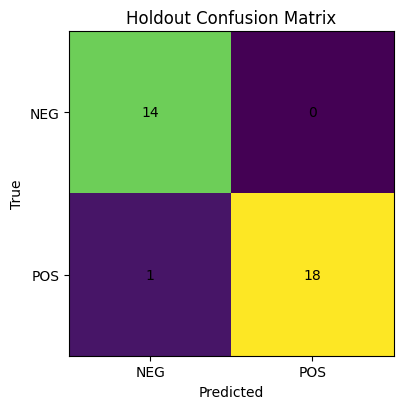

In [46]:
# HOLDOUT CONFUSION MATRIX

cm = confusion_matrix(y_hold, pred_hold)

plt.figure(figsize=(4.8,4.2))
plt.imshow(cm)
plt.title("Holdout Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i,j]), ha="center", va="center")

plt.xticks([0,1], ["NEG","POS"])
plt.yticks([0,1], ["NEG","POS"])
plt.tight_layout()
plt.show()

In [48]:
# SIGNATURE (NON-ZERO COEFFICIENT GENES)
coef = final_model.coef_.ravel()
coef_df = pd.DataFrame({
    "feature_id": selected_genes,
    "feature_label": [pretty_label(g) for g in selected_genes],
    "coef": coef,
    "abs_coef": np.abs(coef),
}).sort_values("abs_coef", ascending=False)

# non-zero (elastic net sparsity)
nz = coef_df[coef_df["abs_coef"] > 1e-8].copy()
print("Selected genes (top_k):", len(selected_genes))
print("Non-zero genes in final elastic-net:", nz.shape[0])

display(nz.head(30))

# Save
nz.to_csv(p("final_signature_nonzero_genes.csv"), index=False)
coef_df.to_csv(p("final_signature_all_selected_genes.csv"), index=False)
print("Saved:\n ", p("final_signature_nonzero_genes.csv"), "\n ", p("final_signature_all_selected_genes.csv"))

Selected genes (top_k): 50
Non-zero genes in final elastic-net: 29


,feature_id,feature_label,coef,abs_coef
29,8089928,8089928,-1.139344,1.139344
2,7953901,7953901 (CLEC12A),0.969864,0.969864
1,8095694,8095694 (PF4V1),0.784339,0.784339
36,8125436,8125436 (HLA-DRB5),0.678996,0.678996
3,7961102,7961102 (CLEC1B),0.567784,0.567784
49,8019802,8019802,0.534168,0.534168
43,8071051,8071051 (LOC100233156),-0.491895,0.491895
15,8173135,8173135 (ALAS2),0.459578,0.459578
26,8138545,8138545,0.452601,0.452601
4,8149137,8149137 (DEFA1B),-0.438747,0.438747


Saved:
  results/final_signature_nonzero_genes.csv 
  results/final_signature_all_selected_genes.csv


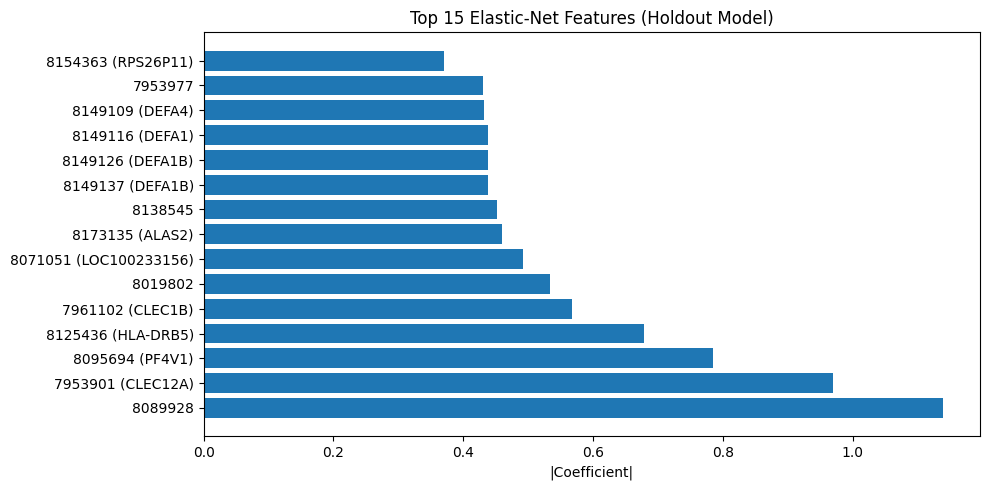

In [50]:
# TOP FEATURES PLOT (LABELED)
topN = 15
top_plot = nz.head(topN)

plt.figure(figsize=(10,5))
plt.barh(range(len(top_plot))[::-1], top_plot["abs_coef"].values[::-1])
plt.yticks(range(len(top_plot))[::-1], top_plot["feature_label"].values[::-1])
plt.xlabel("|Coefficient|")
plt.title(f"Top {topN} Elastic-Net Features (Holdout Model)")
plt.tight_layout()
plt.show()

In [54]:
# STABILITY SELECTION (REPEATED SPLITS)

from collections import Counter

def fit_once_and_get_nonzero(expr_full, y_full, seed,
                             top_k=100, rank_method="score",
                             C=1.0, l1_ratio=0.5,
                             hvg_k=2000, test_size=0.2):

    samples = np.array(expr_full.columns)
    tr_s, ho_s, y_tr, y_ho = train_test_split(
        samples, y_full, test_size=test_size, stratify=y_full, random_state=seed
    )

    expr_tr = expr_full[tr_s]
    expr_ho = expr_full[ho_s]

    # HVG on TRAIN only
    hvg = expr_tr.var(axis=1).sort_values(ascending=False).head(hvg_k).index
    expr_tr = expr_tr.loc[hvg]
    expr_ho = expr_ho.loc[hvg]

    # rank on TRAIN only
    sel, _ = rank_genes_train_only(expr_tr, y_tr, method=rank_method, top_k=top_k)

    Xtr = expr_tr.loc[sel].T.values
    Xho = expr_ho.loc[sel].T.values

    sc = StandardScaler()
    Xtr = sc.fit_transform(Xtr)
    Xho = sc.transform(Xho)

    clf = LogisticRegression(
        penalty="elasticnet", solver="saga",
        l1_ratio=l1_ratio, C=C,
        max_iter=8000, class_weight="balanced",
        random_state=seed
    )
    clf.fit(Xtr, y_tr)

    proba = clf.predict_proba(Xho)[:,1]
    auc = roc_auc_score(y_ho, proba)

    coef = clf.coef_.ravel()
    nz_genes = [g for g,c in zip(sel, coef) if abs(c) > 1e-8]
    return auc, nz_genes

# run repeats
STAB_REPEATS = 50
stab_counts = Counter()
stab_aucs = []

for seed in range(1, STAB_REPEATS+1):
    auc_i, nz_genes_i = fit_once_and_get_nonzero(
        expr, y, seed,
        top_k=top_k_best,
        rank_method=rank_best,
        C=C_best,
        l1_ratio=l1_best,
        hvg_k=2000,
        test_size=0.2
    )
    stab_aucs.append(auc_i)
    stab_counts.update(nz_genes_i)

print("Stability AUC mean/std:", float(np.mean(stab_aucs)), float(np.std(stab_aucs)))
print("Unique genes ever selected:", len(stab_counts))

stab_df = pd.DataFrame({
    "gene_id": list(stab_counts.keys()),
    "gene_label": [pretty_label(g) for g in stab_counts.keys()],
    "selected_count": list(stab_counts.values()),
    "selected_freq": [v / STAB_REPEATS for v in stab_counts.values()]
}).sort_values("selected_freq", ascending=False)

display(stab_df.head(30))
stab_df.to_csv(p("stability_selection_gene_frequency.csv"), index=False)
print("Saved:", p("stability_selection_gene_frequency.csv"))

Stability AUC mean/std: 0.9988721804511278 0.0037025781209759643
Unique genes ever selected: 86


,gene_id,gene_label,selected_count,selected_freq
3,8095694,8095694 (PF4V1),50,1.00
5,7961102,7961102 (CLEC1B),50,1.00
6,7953901,7953901 (CLEC12A),50,1.00
7,8173135,8173135 (ALAS2),50,1.00
11,7953977,7953977,50,1.00
0,8149137,8149137 (DEFA1B),49,0.98
2,8149116,8149116 (DEFA1),49,0.98
1,8149126,8149126 (DEFA1B),49,0.98
9,8062312,8062312 (MYL9),46,0.92
25,8071051,8071051 (LOC100233156),45,0.90


Saved: results/stability_selection_gene_frequency.csv


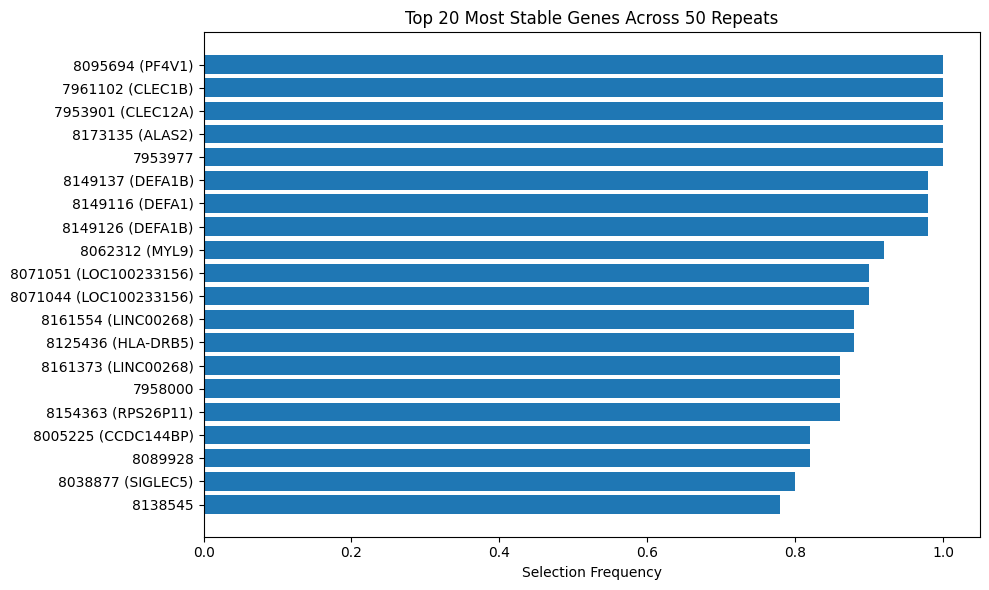

In [56]:
# PLOT STABILITY (TOP 20)

topM = 20
top_stable = stab_df.head(topM).iloc[::-1]

plt.figure(figsize=(10,6))
plt.barh(top_stable["gene_label"], top_stable["selected_freq"])
plt.xlabel("Selection Frequency")
plt.title(f"Top {topM} Most Stable Genes Across {STAB_REPEATS} Repeats")
plt.tight_layout()
plt.show()

Real AUC mean: 0.9985526315789472
Permuted AUC mean: 0.4975751879699248
Empirical p-value: 0.004975124378109453


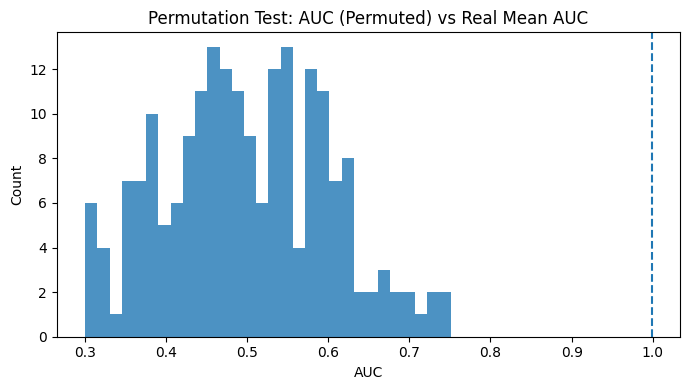

Saved: results/permutation_test_aucs.csv


In [58]:
# PERMUTATION TEST (LABEL SHUFFLE)

def eval_pipeline_auc(expr_full, y_full, seed,
                      top_k, rank_method, C, l1_ratio,
                      hvg_k=2000, test_size=0.2):

    samples = np.array(expr_full.columns)
    tr_s, ho_s, y_tr, y_ho = train_test_split(
        samples, y_full, test_size=test_size, stratify=y_full, random_state=seed
    )

    expr_tr = expr_full[tr_s]
    expr_ho = expr_full[ho_s]

    hvg = expr_tr.var(axis=1).sort_values(ascending=False).head(hvg_k).index
    expr_tr = expr_tr.loc[hvg]
    expr_ho = expr_ho.loc[hvg]

    sel, _ = rank_genes_train_only(expr_tr, y_tr, method=rank_method, top_k=top_k)

    Xtr = expr_tr.loc[sel].T.values
    Xho = expr_ho.loc[sel].T.values

    sc = StandardScaler()
    Xtr = sc.fit_transform(Xtr)
    Xho = sc.transform(Xho)

    clf = LogisticRegression(
        penalty="elasticnet", solver="saga",
        l1_ratio=l1_ratio, C=C,
        max_iter=8000, class_weight="balanced",
        random_state=seed
    )
    clf.fit(Xtr, y_tr)

    proba = clf.predict_proba(Xho)[:,1]
    return roc_auc_score(y_ho, proba)

PERM_N = 200
rng = np.random.default_rng(42)

real_aucs = []
perm_aucs = []

for i in range(PERM_N):
    seed = int(rng.integers(1, 10_000_000))

    # real
    real_aucs.append(eval_pipeline_auc(
        expr, y, seed,
        top_k=top_k_best, rank_method=rank_best,
        C=C_best, l1_ratio=l1_best
    ))

    # permuted labels
    y_perm = rng.permutation(y)
    perm_aucs.append(eval_pipeline_auc(
        expr, y_perm, seed,
        top_k=top_k_best, rank_method=rank_best,
        C=C_best, l1_ratio=l1_best
    ))

real_mean = float(np.mean(real_aucs))
perm_mean = float(np.mean(perm_aucs))
p_emp = (np.sum(np.array(perm_aucs) >= real_mean) + 1) / (PERM_N + 1)

print("Real AUC mean:", real_mean)
print("Permuted AUC mean:", perm_mean)
print("Empirical p-value:", p_emp)

# plot
plt.figure(figsize=(7,4))
plt.hist(perm_aucs, bins=30, alpha=0.8)
plt.axvline(real_mean, linestyle="--")
plt.title("Permutation Test: AUC (Permuted) vs Real Mean AUC")
plt.xlabel("AUC")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

pd.DataFrame({"real_auc": real_aucs, "perm_auc": perm_aucs}).to_csv(p("permutation_test_aucs.csv"), index=False)
print("Saved:", p("permutation_test_aucs.csv"))

In [60]:
# SAVE FINAL ARTIFACTS

artifact = {
    "model": final_model,
    "scaler": scaler,
    "hvg_k": HVG_K,
    "top_k": top_k_best,
    "rank_method": rank_best,
    "C": C_best,
    "l1_ratio": l1_best,
    "hvg_train_genes": list(hvg_train),
    "selected_genes": list(selected_genes),
    "pos_label": POS_LABEL,
    "neg_label": NEG_LABEL,
}

joblib.dump(artifact, p("final_sleep_model_artifact.joblib"))
print("Saved:", p("final_sleep_model_artifact.joblib"))

Saved: results/final_sleep_model_artifact.joblib


In [68]:
# TRAIN / HOLDOUT SPLIT (ONCE)

from sklearn.model_selection import train_test_split

SEED = 42
holdout_frac = 0.20

train_cols, hold_cols, y_train, y_hold = train_test_split(
    expr.columns.values,
    y,
    test_size=holdout_frac,
    stratify=y,
    random_state=SEED
)

expr_train = expr[train_cols]
expr_hold  = expr[hold_cols]

print("Train:", expr_train.shape, "Holdout:", expr_hold.shape)
print("y_train balance:", np.bincount(y_train), "y_hold balance:", np.bincount(y_hold))

Train: (8506, 130) Holdout: (8506, 33)
y_train balance: [57 73] y_hold balance: [14 19]


In [72]:
# BEST SETTINGS 
top_k_best   = 100           
rank_best    = "padj"        
C_best       = 10.0          
l1_best      = 0.8           
use_hvg_best = True
hvg_k_best   = 2000

print(top_k_best, rank_best, C_best, l1_best)

100 padj 10.0 0.8


In [74]:
# FINAL TRAIN - HOLDOUT EVALUATION 

# HVG on TRAIN only
if use_hvg_best:
    hvg = expr_train.var(axis=1).sort_values(ascending=False).head(hvg_k_best).index
    expr_tr_use = expr_train.loc[hvg]
    expr_ho_use = expr_hold.loc[hvg]
else:
    expr_tr_use = expr_train.copy()
    expr_ho_use = expr_hold.copy()

# Rank genes on TRAIN only
selected_genes, stats_train = rank_genes_train_only(
    expr_tr_use, y_train, method=rank_best, top_k=top_k_best
)

Xtr = expr_tr_use.loc[selected_genes].T.values
Xho = expr_ho_use.loc[selected_genes].T.values

sc = StandardScaler()
Xtr = sc.fit_transform(Xtr)
Xho = sc.transform(Xho)

clf_final = LogisticRegression(
    penalty="elasticnet", solver="saga",
    l1_ratio=l1_best, C=C_best,
    max_iter=8000, class_weight="balanced",
    random_state=SEED
)
clf_final.fit(Xtr, y_train)

proba_hold = clf_final.predict_proba(Xho)[:,1]
pred_hold  = (proba_hold >= 0.5).astype(int)

print("HOLDOUT AUC:", roc_auc_score(y_hold, proba_hold))
print("HOLDOUT PR-AUC:", average_precision_score(y_hold, proba_hold))
print("HOLDOUT Balanced Acc:", balanced_accuracy_score(y_hold, pred_hold))
print("\nClassification report:\n", classification_report(y_hold, pred_hold))

HOLDOUT AUC: 1.0
HOLDOUT PR-AUC: 1.0
HOLDOUT Balanced Acc: 1.0

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        19

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



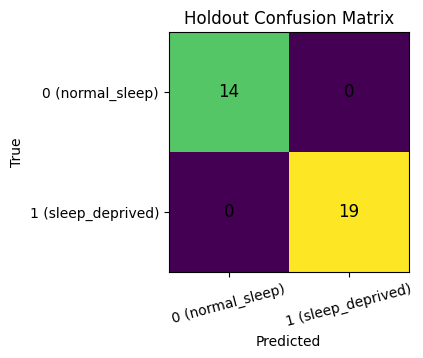

TN FP / FN TP =
[[14  0]
 [ 0 19]]


In [76]:
# Holdout Confusion Matrix 

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_hold, pred_hold)

plt.figure(figsize=(4.2,4.0))
plt.imshow(cm)
plt.title("Holdout Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=12)
plt.xticks([0,1], [f"0 ({NEG_LABEL})", f"1 ({POS_LABEL})"], rotation=15)
plt.yticks([0,1], [f"0 ({NEG_LABEL})", f"1 ({POS_LABEL})"])
plt.tight_layout()
plt.show()

print("TN FP / FN TP =")
print(cm)

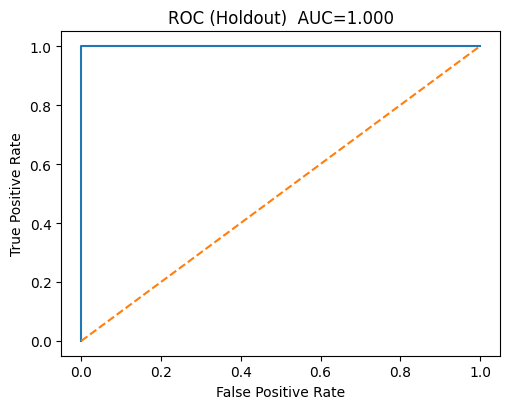

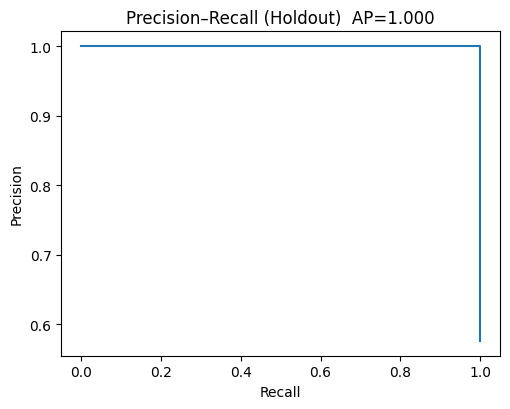

In [78]:
# ROC + PR curves (Holdout)

from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

auc = roc_auc_score(y_hold, proba_hold)
ap  = average_precision_score(y_hold, proba_hold)

fpr, tpr, _ = roc_curve(y_hold, proba_hold)
prec, rec, _ = precision_recall_curve(y_hold, proba_hold)

plt.figure(figsize=(5.2,4.2))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC (Holdout)  AUC={auc:.3f}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5.2,4.2))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall (Holdout)  AP={ap:.3f}")
plt.tight_layout()
plt.show()

Real holdout AUC: 1.0
Permuted AUC mean: 0.4863157894736842
Permuted AUC std: 0.10953086067814619
Empirical p-value: 0.004975124378109453


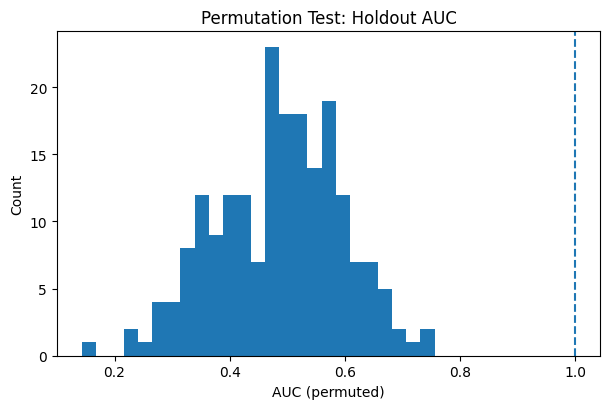

In [80]:
# Permutation Test

from sklearn.metrics import roc_auc_score

N_PERM = 200
rng = np.random.RandomState(SEED)

perm_aucs = []

for i in range(N_PERM):
    y_perm = rng.permutation(y_train)

    # HVG computed on TRAIN only 
    if use_hvg_best:
        hvg = expr_train.var(axis=1).sort_values(ascending=False).head(hvg_k_best).index
        expr_tr_use = expr_train.loc[hvg]
        expr_ho_use = expr_hold.loc[hvg]
    else:
        expr_tr_use = expr_train.copy()
        expr_ho_use = expr_hold.copy()

    # Rank genes on TRAIN only with permuted labels
    sel_perm, _ = rank_genes_train_only(expr_tr_use, y_perm, method=rank_best, top_k=top_k_best)

    Xtr_p = expr_tr_use.loc[sel_perm].T.values
    Xho_p = expr_ho_use.loc[sel_perm].T.values

    scp = StandardScaler()
    Xtr_p = scp.fit_transform(Xtr_p)
    Xho_p = scp.transform(Xho_p)

    clf_p = LogisticRegression(
        penalty="elasticnet", solver="saga",
        l1_ratio=l1_best, C=C_best,
        max_iter=8000, class_weight="balanced",
        random_state=SEED
    )
    clf_p.fit(Xtr_p, y_perm)

    proba_p = clf_p.predict_proba(Xho_p)[:,1]
    perm_aucs.append(roc_auc_score(y_hold, proba_p))

perm_aucs = np.array(perm_aucs)

real_auc = roc_auc_score(y_hold, proba_hold)
p_emp = (np.sum(perm_aucs >= real_auc) + 1) / (N_PERM + 1)

print("Real holdout AUC:", real_auc)
print("Permuted AUC mean:", float(perm_aucs.mean()))
print("Permuted AUC std:", float(perm_aucs.std()))
print("Empirical p-value:", float(p_emp))

plt.figure(figsize=(6.2,4.2))
plt.hist(perm_aucs, bins=25)
plt.axvline(real_auc, linestyle="--")
plt.title("Permutation Test: Holdout AUC")
plt.xlabel("AUC (permuted)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

,selection_freq
feature_id,
7958000,1.0
7935180,1.0
7953901,1.0
8095694,1.0
8059097,1.0
7958253,1.0
8173135,1.0
8021081,1.0
8043413,1.0


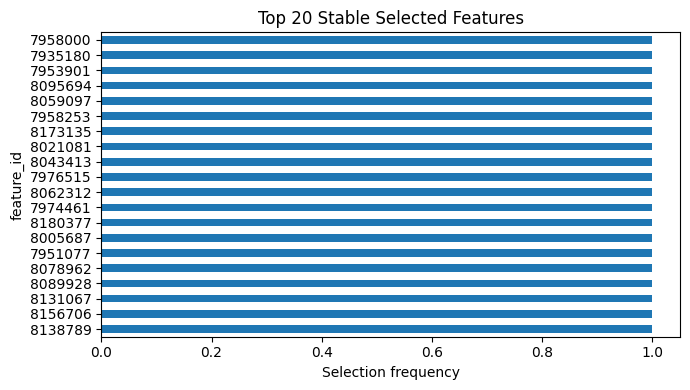

In [82]:
# Stability selection 

N_REPEATS = 100
subsample_frac = 0.80
rng = np.random.RandomState(SEED)

cols_all = expr_train.columns.values
selected_all = []

for r in range(N_REPEATS):
    idx_pos = np.where(y_train == 1)[0]
    idx_neg = np.where(y_train == 0)[0]

    keep_pos = rng.choice(idx_pos, size=max(2, int(len(idx_pos)*subsample_frac)), replace=False)
    keep_neg = rng.choice(idx_neg, size=max(2, int(len(idx_neg)*subsample_frac)), replace=False)
    keep = np.concatenate([keep_pos, keep_neg])

    sub_cols = cols_all[keep]
    y_sub = y_train[keep]
    expr_sub = expr_train[sub_cols]

    if use_hvg_best:
        hvg = expr_sub.var(axis=1).sort_values(ascending=False).head(hvg_k_best).index
        expr_sub = expr_sub.loc[hvg]

    sel, _ = rank_genes_train_only(expr_sub, y_sub, method=rank_best, top_k=top_k_best)
    selected_all.extend(sel)

freq = pd.Series(selected_all).value_counts()
freq = (freq / N_REPEATS).rename("selection_freq").to_frame()
freq.index.name = "feature_id"

display(freq.head(20))

plt.figure(figsize=(7,4))
freq.head(20)["selection_freq"].iloc[::-1].plot(kind="barh")
plt.title("Top 20 Stable Selected Features")
plt.xlabel("Selection frequency")
plt.tight_layout()
plt.show()

In [84]:
# Map IDs to gene symbols + export stable signature

os.makedirs("publication_outputs", exist_ok=True)

freq_out = freq.copy()
freq_out["gene_symbol"] = [probe_to_symbol.get(str(i), np.nan) for i in freq_out.index.astype(str)]
freq_out.to_csv("publication_outputs/stability_selection_all.csv")

stable_thr = 0.60
stable_sig = freq_out[freq_out["selection_freq"] >= stable_thr].copy()
stable_sig.to_csv("publication_outputs/stable_signature.csv")

print("Saved:")
print(" - publication_outputs/stability_selection_all.csv")
print(" - publication_outputs/stable_signature.csv")
print("Stable genes (freq >= %.2f): %d" % (stable_thr, stable_sig.shape[0]))

Saved:
 - publication_outputs/stability_selection_all.csv
 - publication_outputs/stable_signature.csv
Stable genes (freq >= 0.60): 71


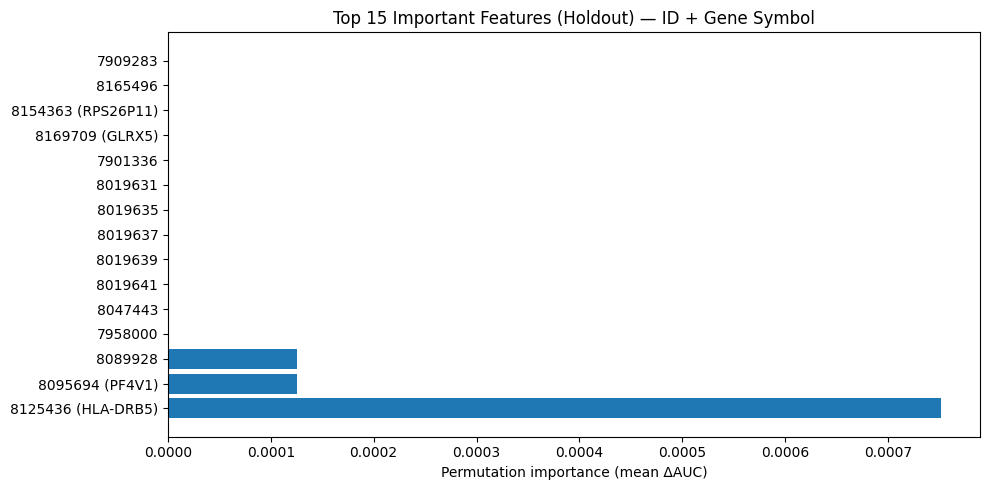

Saved: publication_outputs/top15_importances.csv


In [86]:
# Feature importance plot with ID + gene symbols
from sklearn.inspection import permutation_importance


perm = permutation_importance(
    clf_final, Xho, y_hold,
    n_repeats=30,
    random_state=SEED,
    scoring="roc_auc"
)

imp = pd.Series(perm.importances_mean, index=selected_genes).sort_values(ascending=False)
top15 = imp.head(15)

labels = [pretty_label(g) for g in top15.index]

plt.figure(figsize=(10,5))
plt.barh(range(len(top15))[::-1], top15.values[::-1])
plt.yticks(range(len(top15))[::-1], labels[::-1])
plt.xlabel("Permutation importance (mean ΔAUC)")
plt.title("Top 15 Important Features (Holdout) — ID + Gene Symbol")
plt.tight_layout()
plt.show()

# Save table too
fi = pd.DataFrame({
    "feature_id": top15.index.astype(str),
    "gene_symbol": [probe_to_symbol.get(str(g), np.nan) for g in top15.index.astype(str)],
    "importance": top15.values
})
fi.to_csv("publication_outputs/top15_importances.csv", index=False)
print("Saved: publication_outputs/top15_importances.csv")